# Маркетплейс новых бразильских товаров — масштабирование продаж и поиск драйверов роста

## Импорт необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
from dateutil import parser
import matplotlib.pylab as plt
import seaborn as sns
from operator import attrgetter

## Загрузка данных

In [2]:
orders = pd.read_csv('olist_orders_dataset.csv')
users = pd.read_csv('olist_customers_dataset.csv')
order_items = pd.read_csv('olist_order_items_dataset.csv')

## Анализ данных

Посмотрим на структуру данных и определим, какие статусы заказов будем учитывать для анализа retention

In [3]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [4]:
orders.groupby('order_status').order_id.nunique()

order_status
approved           2
canceled         625
created            5
delivered      96478
invoiced         314
processing       301
shipped         1107
unavailable      609
Name: order_id, dtype: int64

Для анализа retention мы будем учитывать только статусы заказов, которые означают успешное завершение покупки, такие как delivered.

## Рассчитаем retention

In [5]:
# Преобразование времени в datetime
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])

# Создание столбца с годом и месяцем покупки
orders['order_month'] = orders['order_purchase_timestamp'].dt.to_period('M')

# Фильтрация только успешных заказов
successful_orders = orders[(orders['order_status'] == 'delivered')]

# Получение уникального id пользователя по заказу
successful_orders_transf = successful_orders.merge(users[['customer_id', 'customer_unique_id']],
                                                   on='customer_id',
                                                   how='left')

# Создаём копию данных, чтобы избежать изменений в исходном DataFrame
data_copy = successful_orders_transf.copy()

# Извлекаем день заказа
data_copy['order_period_day'] = data_copy['order_purchase_timestamp'].dt.to_period('D')

# Присваиваем когорты на основе даты первого действия для каждого пользователя
data_copy['cohort'] = data_copy.groupby('customer_unique_id')['order_purchase_timestamp'].transform('min').dt.to_period('M')
data_copy['cohort_day'] = data_copy.groupby('customer_unique_id')['order_purchase_timestamp'].transform('min').dt.to_period('D')

# Рассчитываем номер периода в днях (месячные периоды, деля на 30)
data_copy['period_number_month'] = np.floor((data_copy.order_period_day - data_copy.cohort_day).apply(attrgetter('n')) / 30)

# Агрегируем данные по когортам и рассчитанному номеру периода (в месяцах)
df_cohort = data_copy.groupby(['cohort', 'period_number_month']).agg(n_customers=('customer_unique_id', 'nunique')).reset_index()

# Создаём сводную таблицу для когортного анализа
cohort_pivot = df_cohort.pivot_table(index='cohort', columns='period_number_month', values='n_customers')

# Рассчитываем размеры когорт (первый столбец сводной таблицы)
cohort_size = cohort_pivot.iloc[:, 0]

# Вычисляем коэффициенты удержания, деля на размер когорты
retention_matrix = cohort_pivot.divide(cohort_size, axis=0)

In [6]:
cohort_pivot

period_number_month,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,11.0,12.0,13.0,14.0,15.0,16.0,17.0,19.0,20.0,21.0
cohort,,,,,,,,,,,,,,,,,,,,,
2016-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,262.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,...,1.0,NaN,1.0,NaN,1.0,NaN,1.0,2.0,1.0,1.0
2016-12,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,717.0,2.0,NaN,4.0,1.0,1.0,2.0,2.0,NaN,NaN,...,4.0,3.0,2.0,NaN,2.0,2.0,2.0,1.0,NaN,NaN
2017-02,1628.0,2.0,3.0,6.0,4.0,2.0,4.0,1.0,2.0,4.0,...,6.0,1.0,3.0,2.0,1.0,1.0,3.0,NaN,NaN,NaN
2017-03,2503.0,7.0,13.0,11.0,3.0,2.0,9.0,4.0,6.0,6.0,...,4.0,4.0,3.0,7.0,2.0,3.0,2.0,NaN,NaN,NaN
2017-04,2256.0,8.0,6.0,1.0,6.0,8.0,6.0,10.0,5.0,6.0,...,3.0,NaN,2.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN
2017-05,3451.0,14.0,14.0,8.0,13.0,11.0,11.0,4.0,10.0,9.0,...,11.0,6.0,3.0,7.0,4.0,NaN,NaN,NaN,NaN,NaN
2017-06,3037.0,13.0,15.0,11.0,5.0,16.0,9.0,6.0,4.0,10.0,...,9.0,3.0,9.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
retention_matrix

period_number_month,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,11.0,12.0,13.0,14.0,15.0,16.0,17.0,19.0,20.0,21.0
cohort,,,,,,,,,,,,,,,,,,,,,
2016-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,1.0,NaN,NaN,NaN,NaN,NaN,0.003817,NaN,NaN,0.003817,...,0.003817,NaN,0.003817,NaN,0.003817,NaN,0.003817,0.007634,0.003817,0.003817
2016-12,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,1.0,0.002789,NaN,0.005579,0.001395,0.001395,0.002789,0.002789,NaN,NaN,...,0.005579,0.004184,0.002789,NaN,0.002789,0.002789,0.002789,0.001395,NaN,NaN
2017-02,1.0,0.001229,0.001843,0.003686,0.002457,0.001229,0.002457,0.000614,0.001229,0.002457,...,0.003686,0.000614,0.001843,0.001229,0.000614,0.000614,0.001843,NaN,NaN,NaN
2017-03,1.0,0.002797,0.005194,0.004395,0.001199,0.000799,0.003596,0.001598,0.002397,0.002397,...,0.001598,0.001598,0.001199,0.002797,0.000799,0.001199,0.000799,NaN,NaN,NaN
2017-04,1.0,0.003546,0.002660,0.000443,0.002660,0.003546,0.002660,0.004433,0.002216,0.002660,...,0.001330,NaN,0.000887,0.000887,0.000887,0.000887,NaN,NaN,NaN,NaN
2017-05,1.0,0.004057,0.004057,0.002318,0.003767,0.003187,0.003187,0.001159,0.002898,0.002608,...,0.003187,0.001739,0.000869,0.002028,0.001159,NaN,NaN,NaN,NaN,NaN
2017-06,1.0,0.004281,0.004939,0.003622,0.001646,0.005268,0.002963,0.001976,0.001317,0.003293,...,0.002963,0.000988,0.002963,0.001317,NaN,NaN,NaN,NaN,NaN,NaN


Теперь рассчитаем усредненный retention за первый месяц по всем когортам.

In [8]:
# Усреднённый retention за первый месяц
average_retention_first_month = retention_matrix[1].median()
print(f'Медианный retention за первый месяц: {average_retention_first_month:.4f}')

Медианный retention за первый месяц: 0.0035


In [9]:
# Поиск когорты с самым высоким retention на третий месяц (когорта с индексом 3)
highest_retention_third_month = retention_matrix[3].idxmax()
highest_retention_value = retention_matrix[3].max()

print(f'Когорта с самым высоким retention на третий месяц: {highest_retention_third_month}, значение: {highest_retention_value:.4f}%')

Когорта с самым высоким retention на третий месяц: 2017-01, значение: 0.0056%


## Определим, существует ли product/market fit у маркетплейса

Исходя из матрицы когортного анализа данный продукт имеет слабый product/market fit.

1. Привлечение новых клиентов: Когортный анализ показывает, что каждый месяц в продукт приходит значительное количество новых клиентов, с медианным значением в 4057 клиентов. Этот стабильный поток новых пользователей указывает на то, что маркетплейс способен привлекать интересующихся клиентов, которые готовы совершать покупки. Однако важно отметить, что наличие стабильного потока новых клиентов не всегда гарантирует долгосрочный успех бизнеса.

2. Проблемы удержания клиентов: Несмотря на привлекательность для новых пользователей, когортный анализ показывает, что лишь 0.3% клиентов (по медиане) остаются активными на первый месяц после первой покупки, а на второй месяц этот показатель значительно снижается до нуля. Это говорит о том, что большинство новых пользователей не находят достаточной ценности в продукте или услуге, чтобы продолжать использовать его. Высокий уровень оттока на ранних этапах взаимодействия с продуктом указывает на потенциальные проблемы с его качеством, функциональностью или соответствием ожиданиям клиентов.

3. Необходимость в улучшении ценностного предложения: Низкий уровень удержания клиентов может свидетельствовать о том, что маркетплейс не предоставляет достаточной ценности или уникальности по сравнению с конкурентами. Это может быть связано с недостаточной дифференциацией продукта, проблемами с качеством обслуживания или отсутствием необходимых функций и услуг.

В целом, текущие данные о retention указывают на слабый product/market fit для данного маркетплейса. Стабильный поток новых клиентов является положительным знаком, однако низкий уровень удержания сигнализирует о необходимости серьезных изменений в подходе к продукту и клиентскому обслуживанию.


#### Проверим несколько теорий и попытаемся определить причины низкого PMF.

Проблема в скорости доставки? Проанализируем время доставки от момента заказа до его получения.

In [10]:
# Преобразование времени в datetime
data_copy['order_delivered_customer_date'] = pd.to_datetime(data_copy['order_delivered_customer_date'])
data_copy['order_estimated_delivery_date'] = pd.to_datetime(data_copy['order_estimated_delivery_date'])

# Посчитаем сколько времени занимает доставка
data_copy['delivery_in_time'] = data_copy['order_estimated_delivery_date'] - data_copy['order_delivered_customer_date']

# Преобразуем в дни, чтобы понять, доставка заняла больше времени, чем предполагалось или нет
data_copy['delivery_in_time'] = data_copy['delivery_in_time'].dt.days

# Сгруппируем по месяцам "order_period" и посмотрим на процент заказов доставленных с опозданием
data_copy['order_period'] = data_copy['order_purchase_timestamp'].dt.to_period('M')

# Заказы доставленные с опозданием
orders_late = data_copy.query('delivery_in_time < 0').groupby('order_period', as_index=False).agg(orders_late=('order_id', 'count'))

# Заказы доставленные в срок
orders_ok = data_copy.query('delivery_in_time > 0').groupby('order_period', as_index=False).agg(orders_ok=('order_id', 'count'))

orders_by_period = orders_late.merge(orders_ok, on='order_period')

# Процент заказов доставленных с опозданием
orders_by_period['ratio'] = 100 * orders_by_period['orders_late'] / orders_by_period['orders_ok']

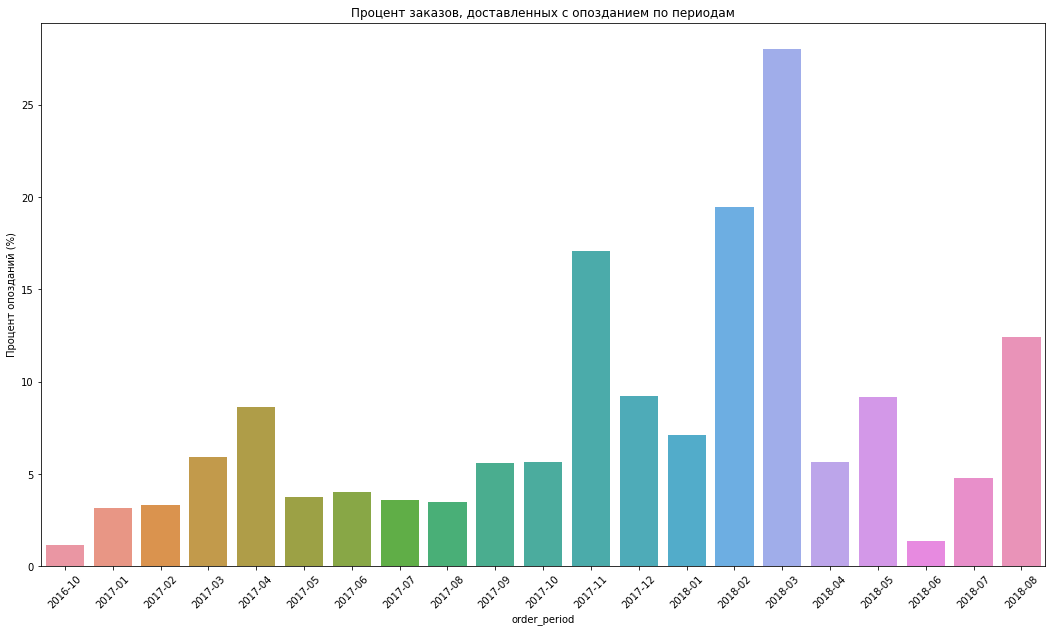

In [11]:
# Построим график для наглядности
plt.figure(figsize=(18, 10))
sns.barplot(x='order_period', y='ratio', data=orders_by_period)

plt.title('Процент заказов, доставленных с опозданием по периодам')
plt.ylabel('Процент опозданий (%)')
plt.xticks(rotation=45)
plt.show()

Видно, что в ноябре 2017, феврале 2018 и марте 2018 (более 25%) сроки доставки превысили средние показатели.
Но нельзя сделать вывод, что этот фактор критически влияет на низкий retention, так как большинство пользователей получают заказы вовремя, но не делаю повторные.
Но над сроками доставки нужно поработать.

Проблема в ассортименте? 

In [12]:
df_items = pd.read_csv('olist_order_items_dataset.csv')

# Количество уникальных товаров заказанных на маркетплейсе
df_items.product_id.nunique()

32951

Маркетплейс обладает обширным ассортиментом товаров в разной ценовой категории

In [13]:
# Посмотрим на ТОП-10 заказываемых товаров
all_data = data_copy.merge(df_items, on='order_id', how='left')

# Топ-20 заказываемых товаров
top_20_ordered_items = all_data.query('order_status != "unavailable" & order_status != "canceled"').groupby(['product_id', 'price'], as_index=False).agg(count=('order_id', 'count')).sort_values(by='count', ascending=False).head(10)
top_20_ordered_items

,product_id,price,count
27851,aca2eb7d00ea1a7b8ebd4e68314663af,69.90,400
24888,99a4788cb24856965c36a24e339b6058,89.90,342
10044,3dd2a17168ec895c781a9191c1e95ad7,149.90,271
14826,5a848e4ab52fd5445cdc07aab1c40e48,122.99,190
7047,2b4609f8948be18874494203496bc318,89.99,186
3468,154e7e31ebfa092203795c972e5804a6,23.99,174
10750,422879e10f46682990de24d770e7f83d,59.90,157
27309,a92930c327948861c015c919a0bcb4a8,78.00,151
20302,7c1bd920dbdf22470b68bde975dd3ccf,58.99,151
33776,d017a2151d543a9885604dc62a3d9dcc,49.00,139


In [14]:
# ТОП-10 пользователей с самым высоким средним чеком
all_data.query('order_status != "unavailable" & order_status != "canceled"') \
    .groupby('customer_unique_id', as_index=False) \
    .agg({'price': 'mean'}) \
    .sort_values(by='price', ascending=False).head(10)

,customer_unique_id,price
80463,dc4802a71eae9be1dd28f5d788ceb526,6735.00
25436,459bef486812aa25204be022145caa62,6729.00
93081,ff4159b92c40ebe40454e3e6a7c35ed6,6499.00
87148,eebb5dda148d3893cdaf5b5ca3040ccb,4690.00
26640,48e1ac109decbb87765a3eade6854098,4590.00
86855,edde2314c6c30e864a128ac95d6b2112,4399.87
91326,fa562ef24d41361e476e748681810e1e,4099.99
73826,ca27f3dac28fb1063faddd424c9d95fa,4059.00
416,011875f0176909c5cf0b14a9138bb691,3999.90
86890,edf81e1f3070b9dac83ec83dacdbb9bc,3999.00


Видим, что товары заказываются разнообразные и в разной ценовой категории. Значит, ЦА релевантна и PCF выбран верный

Пользователям приходится каждый раз создавать новый аккаунт?

In [15]:
# Сколько customer_id приходится на одного уникального пользователя
uniq_customers_accs = all_data.groupby('customer_unique_id') \
    .agg(count=('customer_id', 'count')) \
    .sort_values(by='count', ascending=False)

uniq_customers_accs.head()

,count
customer_unique_id,
c8460e4251689ba205045f3ea17884a1,24
4546caea018ad8c692964e3382debd19,21
698e1cf81d01a3d389d96145f7fa6df8,20
c402f431464c72e27330a67f7b94d4fb,20
0f5ac8d5c31de21d2f25e24be15bbffb,18


Поскольку формируется каждый раз новый customer_id для каждого уникального пользователя при новом заказе. Возможная причина - пользователям приходится каждый раз заново создавать аккаунт, чтобы заказать товар.

Таким образом маркетплейсу нужно сконцентрироваться на следующем:
1. Проверить, почему формируется новый customer_id для каждого уникального пользователя
2. Внедрить систему напоминания о себе (рассылки, акции и т.д.)
3. Проверить процент возвратов, либо внедрить такую опцию, если ее нет
Одна из возможных причин низкого retention - низкое качество товаров, пользователи недовольны полученным товаром, он не соответствует тому, что было заявлено - проверить отзывы. 
4. Проверить работу службы поддержки, возможность контакта с продавцом, либо добавить ее при их отсутствии
5. Проверить работу курьеров

## Определим основные метрики, на которых можно сконцентрироваться, чтобы максимизировать прибыль компании

### 1) Общий объем продаж (Gross Merchandise Volume, GMV)

Описание: Эта метрика отражает общий объем продаж через маркетплейс за определенный период. Она показывает, насколько успешно маркетплейс привлекает покупателей и генерирует доход.

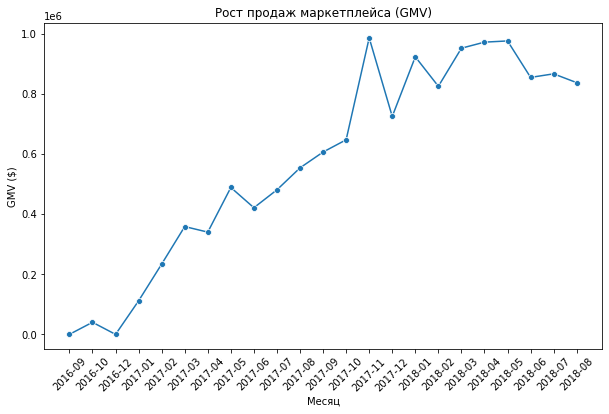

In [16]:
# Расчет GMV
gmv_data = successful_orders.merge(order_items[['order_id', 'price']], on='order_id')
monthly_gmv = gmv_data.groupby('order_month')['price'].sum().reset_index()
monthly_gmv['order_month'] = monthly_gmv['order_month'].astype(str)
monthly_gmv.columns = ['order_month', 'GMV']

plt.figure(figsize=(10, 6))
sns.lineplot(data=monthly_gmv, x='order_month', y='GMV', marker='o')
plt.title('Рост продаж маркетплейса (GMV)')
plt.xlabel('Месяц')
plt.ylabel('GMV ($)')
plt.xticks(rotation=45)

plt.show()

### 2) Количество платящих клиентов (Paying Users)

Описание: Эта метрика показывает количество уникальных пользователей, которые совершают хотя бы один заказ в продукте в течение месяца. Она помогает оценить, сколько клиентов на самом деле извлекают ценность из маркетплейса, то есть находят тот товар, который им нужен.

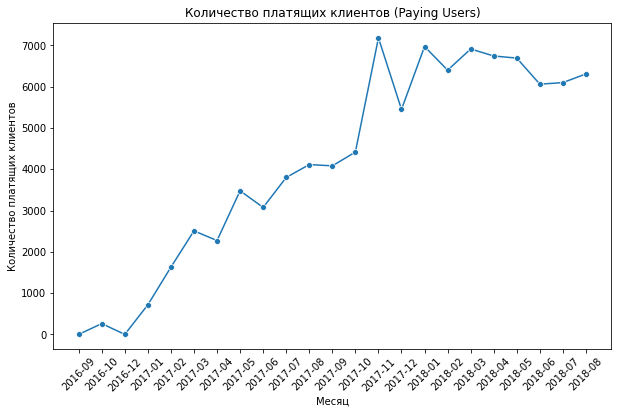

In [17]:
paying_users = successful_orders_transf.groupby(successful_orders_transf['order_month']).customer_unique_id.nunique().reset_index()
paying_users['order_month'] = paying_users['order_month'].astype(str)
paying_users.columns = ['order_month', 'paying_users']

plt.figure(figsize=(10, 6))
sns.lineplot(data=paying_users, x='order_month', y='paying_users', marker='o')
plt.title('Количество платящих клиентов (Paying Users)')
plt.xlabel('Месяц')
plt.ylabel('Количество платящих клиентов')
plt.xticks(rotation=45)

plt.show()

### 3) Конверсия в первую покупку (Conversion to Paying User)

Описание: Эта метрика измеряет процент новых пользователей, которые совершают покупку после первого визита на сайт или в приложение. Она отражает, насколько эффективно маркетплейс привлекает и конвертирует новых клиентов.

### 4) Коэффициент удержания (Retention Rate)

Описание: Эта метрика показывает процент клиентов, которые продолжают использовать продукт после первого месяца. Она помогает понять, насколько хорошо продукт удерживает клиентов и удовлетворяет их потребности.

In [18]:
retention_matrix

period_number_month,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,11.0,12.0,13.0,14.0,15.0,16.0,17.0,19.0,20.0,21.0
cohort,,,,,,,,,,,,,,,,,,,,,
2016-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,1.0,NaN,NaN,NaN,NaN,NaN,0.003817,NaN,NaN,0.003817,...,0.003817,NaN,0.003817,NaN,0.003817,NaN,0.003817,0.007634,0.003817,0.003817
2016-12,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,1.0,0.002789,NaN,0.005579,0.001395,0.001395,0.002789,0.002789,NaN,NaN,...,0.005579,0.004184,0.002789,NaN,0.002789,0.002789,0.002789,0.001395,NaN,NaN
2017-02,1.0,0.001229,0.001843,0.003686,0.002457,0.001229,0.002457,0.000614,0.001229,0.002457,...,0.003686,0.000614,0.001843,0.001229,0.000614,0.000614,0.001843,NaN,NaN,NaN
2017-03,1.0,0.002797,0.005194,0.004395,0.001199,0.000799,0.003596,0.001598,0.002397,0.002397,...,0.001598,0.001598,0.001199,0.002797,0.000799,0.001199,0.000799,NaN,NaN,NaN
2017-04,1.0,0.003546,0.002660,0.000443,0.002660,0.003546,0.002660,0.004433,0.002216,0.002660,...,0.001330,NaN,0.000887,0.000887,0.000887,0.000887,NaN,NaN,NaN,NaN
2017-05,1.0,0.004057,0.004057,0.002318,0.003767,0.003187,0.003187,0.001159,0.002898,0.002608,...,0.003187,0.001739,0.000869,0.002028,0.001159,NaN,NaN,NaN,NaN,NaN
2017-06,1.0,0.004281,0.004939,0.003622,0.001646,0.005268,0.002963,0.001976,0.001317,0.003293,...,0.002963,0.000988,0.002963,0.001317,NaN,NaN,NaN,NaN,NaN,NaN


### 5) ARPPU

Описание: Эта метрика отражает общую выручку, которую компания получает с одного клиента в среднем

In [19]:
# Объединяем с таблицей клиентов для получения customer_unique_id
order_all_info = gmv_data.merge(users[['customer_id', 'customer_unique_id']], on='customer_id')

monthly_revenue = order_all_info.groupby('order_month').agg(
    total_revenue=('price', 'sum'),
    paying_users=('customer_unique_id', 'nunique')).reset_index()

monthly_revenue['ARRPU'] = monthly_revenue['total_revenue'] / monthly_revenue['paying_users']

monthly_revenue[['order_month', 'total_revenue', 'paying_users', 'ARRPU']]

,order_month,total_revenue,paying_users,ARRPU
0,2016-09,134.97,1,134.970000
1,2016-10,40325.11,262,153.912634
2,2016-12,10.90,1,10.900000
3,2017-01,111798.36,718,155.708022
4,2017-02,234223.40,1630,143.695337
5,2017-03,359198.85,2508,143.221232
6,2017-04,340669.68,2274,149.810765
7,2017-05,489338.25,3479,140.654858
8,2017-06,421923.37,3076,137.166245
9,2017-07,481604.52,3802,126.671362


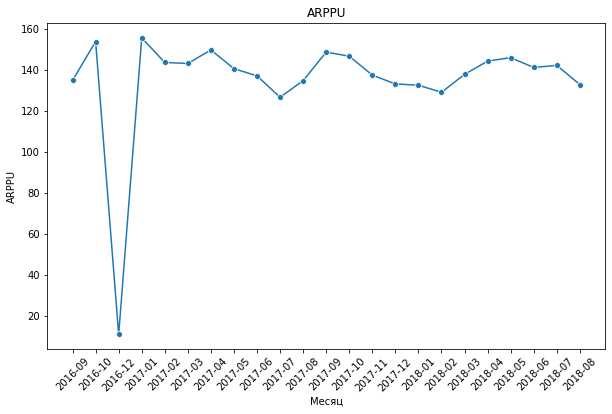

In [20]:
monthly_revenue['order_month'] = monthly_revenue['order_month'].astype(str)

plt.figure(figsize=(10, 6))
sns.lineplot(data=monthly_revenue, x='order_month', y='ARRPU', marker='o')
plt.title('ARPPU')
plt.xlabel('Месяц')
plt.ylabel('ARPPU')
plt.xticks(rotation=45)

plt.show()

Посмотрев на когортный анализ и метрики, было принято решение, что нужно изменить продукт. Метрики необходимо повышать. 
Были сформулированы 3 гипотезы:

Гипотеза 1 - Если исправим баг в системе процессинга заказов, то клиентам не придётся сталкиваться с проблемой отмены заказа, вследствие чего количество доставленных заказов увеличится. Считаем, что мы таким образом избавимся от всех отмен.

Гипотеза 2 - Если сократим время до отгрузки заказа, то клиенты перестанут получать свой заказ с запаздыванием, вследствие чего количество заказов увеличится за счёт повторных заказов. 

Гипотеза 3 - Если создадим новый способ оплаты, который будет конвертировать клиентов в повторный заказ, то клиенты не будут испытывать трудности при оформлении заказа, вследствие чего количество заказов увеличится за счёт повторных заказов тех, кто раньше не делал повторный заказ.

## Применим фреймворк ICE для выбора гипотезы на реализацию

### Гипотеза 1. Confidence - 8, Ease - 6

Для расчета Impact по этой гипотезе можно посчитать количество заказов, который остались в статусе отмены. Заказом в статусе отмены будем считать статусы: canceled, unavailable

In [21]:
orders[orders.order_month >= '2017-06'].groupby('order_status').order_id.nunique()

order_status
canceled         499
created            5
delivered      85413
invoiced         240
processing       202
shipped          912
unavailable      475
Name: order_id, dtype: int64

In [22]:
count_canceled = orders[(orders.order_month >= '2017-06') &
                        (orders.order_status.isin(['canceled', 'unavailable']))].order_id.nunique()
print(f'Количество отмененных заказов: {count_canceled}')

Количество отмененных заказов: 974


### Гипотеза 2. Confidence - 10, Ease - 4

Для расчета Impact по этой гипотезе можно посчитать количество заказов, которые были доставлены с опозданием. Конверсию в повторный заказ возьмем равной 0.0035.

In [23]:
# Преобразование времени в datetime
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'])

# Создание столбца с годом и месяцем покупки
orders['order_delivery_day'] = orders['order_delivered_customer_date'].dt.to_period('D')
orders['order_estimated_day'] = orders['order_estimated_delivery_date'].dt.to_period('D')

count_delayed = orders[(orders.order_month >= '2017-06') & (orders.order_delivery_day > orders.order_estimated_day)
                      & (orders.order_status.isin(['delivered']))].order_id.nunique()

print(f'Количество задержанных заказов: {count_delayed}')
print(f'Возможное количество повторных заказов: {count_delayed*0.0035}')

Количество задержанных заказов: 6087
Возможное количество повторных заказов: 21.3045


### Гипотеза 3. Confidence - 5, Ease - 9

Для расчета Impact по этой гипотезе можно посчитать количество заказов, где клиент сделал только единичный заказ. Конверсию в повторный заказ возьмем равной 0.0035.

In [24]:
# Подсчитываем количество заказов для каждого клиента
customer_order_counts = successful_orders_transf[(successful_orders_transf.order_month >= '2017-06')].groupby('customer_unique_id').order_id.nunique().reset_index()

# Определяем количество клиентов, которые сделали только один заказ
single_order_customers_count = (customer_order_counts == 1).order_id.sum()

customer_order_counts.groupby('order_id').nunique('customer_unique_id')

,customer_unique_id
order_id,
1,80558
2,2137
3,129
4,23
5,9
6,2
7,3
9,1
15,1


In [25]:
print(f'Количество задержанных заказов: {single_order_customers_count}')
print(f'Возможное количество повторных заказов: {single_order_customers_count*0.0035}')

Количество задержанных заказов: 80558
Возможное количество повторных заказов: 281.95300000000003


### При сравнении по фреймворку ICE из 3 гипотез выигрывает гипотеза 1.

## Определим на какие метрики должна повлиять выбранная гипотеза

Для проверки гипотезы о том, что исправление бага в системе процессинга заказов приведет к снижению количества отмен и увеличению количества доставленных заказов, важно определить метрики, которые будут отражать эффективность изменений. Метрики можно разделить на три категории: целевые, прокси и guardrail.

**Целевые метрики**

1. Количество доставленных заказов

    Определение: Общее количество заказов, которые были успешно доставлены клиентам.
    Цель: Оценить, увеличилось ли количество успешных доставок после исправления бага. Это основная метрика, которая непосредственно отражает успех гипотезы.

**Прокси метрики**

2. Конверсия в доставку товара до покупателя

    Определение: Общее количество заказов, которые были доставлены клиентам / Общее количество заказов.
    Цель: Измерить снижение числа отмен после исправления бага. Эта метрика служит индикатором того, насколько эффективно работает система после внесения изменений.

**Guardrail метрики**

3. Конверсия в оформление заказа

    Определение: Доля клиентов, которые оформили заказ, деленная на количество активной аудитории
    Цель: Убедиться, что исправление бага не негативно сказалось на общем восприятии клиента совершить следующий заказ.


## Отчет

#### Проблема: 

Выручка маркетплейса стагнирует из‑за крайне низкого повторного использования сервиса клиентами — лишь 0.3% клиентов (по медиане) остаются активными на первый месяц после первой покупки, а на второй месяц этот показатель значительно снижается до нуля.

#### Общие выводы: 

Продукт демонстрирует слабый product/market fit при хорошем притоке новых пользователей (медиана новых клиентов в месяц — 4 057). Однако этот приток не обеспечивает устойчивого роста: когортный анализ выявил крайне низкий месячный retention на этап оформления заказа — медиана на 1-й месяц ≈ 0.0035.

Проблема — удержание клиентов: большинство новых пользователей не видят достаточной ценности в продукте, чтобы вернуться. Высокий отток на ранних этапах указывает на возможные недостатки в качестве, функциональности или соответствии ожиданиям.

Необходимость усиления ценностного предложения: низкий retention может означать, что маркетплейс не выделяется на рынке, испытывает проблемы с клиентским сервисом или недостаёт ключевых функций и услуг.

Повторные заказы сопровождаются созданием нового customer_id для одного и того же customer_unique_id. Возможно, пользователи не могут зайти в своей аккаунт и им приходится его создавать заново.
Наблюдаются частые нарушения сроков доставки заказов.

Вывод: Стабильный приток новых клиентов — позитивный сигнал, но низкий уровень удержания требует оперативных изменений в продуктовой стратегии и работе с пользователями, чтобы сделать бизнес масштабируемым.

#### На основании посчитанных метрик можно сделать следующие выводы:

1. Наблюдается рост продаж
2. Количество платящих клиентов растет, но только за счет привлечения новой аудитории
3. Низкая вовлеченность клиентов в продолжение использования продукта
4. Общая выручка находится на одном и том же уровне

Для увеличения retention была сформирована и выбрана следующая гипотеза: 

Если исправим баг в системе процессинга заказов, то клиентам не придется сталкиваться с проблемой отмены заказа, вследствие чего количество доставленных заказов увеличится.

Для ее проверки предлагаю использовать следующие метрики:

- Целевая метрика - Количество доставленных заказов
- Прокси‑метрика - Конверсия в доставку товара до покупателя
- Guardrail метрика - Конверсия в оформление заказа

#### Рекомендации по продукту:

- Запустить А/Б тест по исправлению бага в системе процессинга заказов
- Внедрить систему напоминаний после первого заказа с персональными офферами, акциями
- Отслеживать долю возвратов и жалоб, их причины
- Разобраться и исправить причину множественных customer_id для одного customer_unique_id